In [143]:
import pandas as pd
import numpy as np
import sqlite3

mh = pd.read_pickle('~/datascience/burn notice/Data-Science/Data/clean_historical_modis.pkl')

In [146]:
# extract date range from historical modis
mh['acq_date'] =pd.to_datetime(mh['acq_date'])
mh['acq_date'].sort_values()

0         2001-01-01
18        2001-01-01
17        2001-01-01
16        2001-01-01
15        2001-01-01
14        2001-01-01
13        2001-01-01
12        2001-01-01
11        2001-01-01
10        2001-01-01
19        2001-01-01
8         2001-01-01
7         2001-01-01
6         2001-01-01
5         2001-01-01
4         2001-01-01
3         2001-01-01
2         2001-01-01
1         2001-01-01
9         2001-01-01
50        2001-01-02
48        2001-01-02
47        2001-01-02
43        2001-01-02
45        2001-01-02
44        2001-01-02
51        2001-01-02
46        2001-01-02
52        2001-01-02
56        2001-01-02
             ...    
1780517   2016-01-01
1780515   2016-01-01
1780516   2016-01-01
1780518   2016-01-01
1780519   2016-01-01
1780520   2016-01-01
1780521   2016-01-01
1780506   2016-01-01
1780514   2016-01-01
1780505   2016-01-01
1780495   2016-01-01
1780503   2016-01-01
1780522   2016-01-01
1780487   2016-01-01
1780488   2016-01-01
1780489   2016-01-01
1780490   201

In [147]:
mh['acq_date'][:1], mh['acq_date'][-1:]

(0   2001-01-01
 Name: acq_date, dtype: datetime64[ns], 1780523   2016-01-01
 Name: acq_date, dtype: datetime64[ns])

Our historical modis operations are between 2001-01-01 and 2016-01-01. We will extract the exact same date range from our kaggle labelled fires SQL database.

In [149]:
# FPA FOD data from here: https://www.kaggle.com/rtatman/188-million-us-wildfires
# Create the connection
cnx = sqlite3.connect('/home/nedderlander/datascience/burn notice/Data-Science/Data/FPA_FOD_20170508.sqlite')

# create the dataframe from a query
# Fire Program Analysis (FPA) system
kdf = pd.read_sql_query("""SELECT LATITUDE, LONGITUDE, DISCOVERY_DATE, FIRE_YEAR, 
                       DISCOVERY_DOY FROM Fires WHERE FIRE_YEAR > 2001""", cnx)

kdf is a great source for labeling fires but it may be missing 'prescribed burns' which are fires that are intentioinally lit to control forrests. We will try to add in a dataset that includes so-called prescribed burns.

In [150]:
fh_path = '/home/nedderlander/datascience/burn notice/Data-Science/Data/fh_all_1980_2016.csv'
fields = ['STARTDATED', 'DLATITUDE', 'DLONGITUDE' , 'YEAR_']

fhf = pd.read_csv(fh_path, usecols=fields)

Now we will match fhf and kdf to hopefully create a more comprehensive labelling source.

This will involve turning the fhf date to datetime, creating a date from the kdf features Fire_year and DOY, and then fuzzy matching dates and rounded longitudes.

In [151]:
# For our kdf

# create datetime objects and then year and month
import datetime

fire_year = kdf["FIRE_YEAR"].tolist()
day_of_year = kdf["DISCOVERY_DOY"].tolist()

fire_dates = tuple(zip(fire_year, day_of_year))

def to_date(fire_dates):
    dates = []
    for row in fire_dates:
        dates.append(datetime.datetime(row[0], 1, 1) + datetime.timedelta(row[1] - 1))
    return dates

dates = to_date(fire_dates)
kdf['DATE'] = dates
kdf['MONTH'] = kdf['DATE'].dt.month
kdf['WEEK'] = kdf['DATE'].dt.weekofyear


# rename FIREYEAR to year for simplicity
kdf = kdf.rename(columns={'FIRE_YEAR' : 'YEAR'})


In [152]:
# now that we have DATE and MONTH for kdf, we will produce the same features for fhf
fhf['STARTDATED'] = fhf['STARTDATED'].str.replace(" ", "")
fhf['DATE'] = pd.to_datetime(fhf['STARTDATED'], format='%Y/%m/%d', errors='coerce')
fhf['MONTH'] = fhf['DATE'].dt.month
fhf['WEEK'] = fhf['DATE'].dt.weekofyear

# rename YEAR_ to year for simplicity
fhf = fhf.rename(columns={'YEAR_' : 'YEAR'})

In [153]:
# now we will create rounded lat/longs and merge these datasets together
dec = 1
fhf["lat_r"] = round(fhf["DLATITUDE"], dec)
fhf["lon_r"] = round(fhf["DLONGITUDE"], dec)
kdf["lat_r"] = round(kdf["LATITUDE"], dec)
kdf["lon_r"] = round(kdf["LONGITUDE"], dec)

rounded = ['lat_r', 'lon_r', 'YEAR', 'MONTH', 'WEEK']

known_fires = pd.merge(kdf[rounded], fhf[rounded], how= 'outer')

known_fires['fire'] = 1

In [154]:
known_fires.shape, known_fires.head()

((2059496, 6),    lat_r  lon_r  YEAR  MONTH  WEEK  fire
 0   40.0 -121.0  2005    2.0   5.0     1
 1   38.9 -120.4  2004    5.0  20.0     1
 2   39.0 -120.7  2004    5.0  23.0     1
 3   38.6 -119.9  2004    6.0  27.0     1
 4   38.6 -119.9  2004    6.0  27.0     1)

Now that we havea large dataframe of known fires, we will merge this into our historical modis data in order to label the modis observations

In [155]:
# mh.drop(columns='WEEK',inplace=True)

In [156]:
# set our fire labels to zero b/c they are unkown at this point
mh["lat_r"] = round(mh["latitude"], dec)
mh["lon_r"] = round(mh["longitude"], dec)

# create date features to match on as well
mh['YEAR'] = mh['acq_date'].dt.year
mh['MONTH'] = mh['acq_date'].dt.month

In [180]:
label_merge = ['lat_r', 'lon_r', 'YEAR', 'MONTH']

labeled_mh = pd.merge(mh, known_fires, how='left', on = label_merge)

In [181]:
labeled_mh.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,version,bright_t31,frp,daynight,lat_r,lon_r,YEAR,MONTH,WEEK,fire
0,19.3530,-155.0576,400.1,1.0,1.0,2001-01-01,849,Terra,100,modis,311.8,255.8,N,19.4,-155.1,2001,1,NaN,NaN
1,19.3378,-155.0360,311.6,1.0,1.0,2001-01-01,849,Terra,83,modis,296.9,9.8,N,19.3,-155.0,2001,1,NaN,NaN
2,19.3544,-155.0482,322.2,1.0,1.0,2001-01-01,849,Terra,100,modis,293.6,19.6,N,19.4,-155.0,2001,1,NaN,NaN
3,19.3468,-155.0375,362.5,1.0,1.0,2001-01-01,849,Terra,100,modis,303.1,92.9,N,19.3,-155.0,2001,1,NaN,NaN
4,19.3516,-155.0670,313.6,1.0,1.0,2001-01-01,849,Terra,87,modis,291.4,11.8,N,19.4,-155.1,2001,1,NaN,NaN


In [182]:
# we will also remap fires so that nans = 0
labeled_mh = labeled_mh.fillna(0)

# and drop the columns used for labelling
labeled_mh.drop(columns=['YEAR','WEEK', 'MONTH', 'WEEK', 'lat_r', 'lon_r'],inplace=True)

In [183]:
labeled_mh['fire'].value_counts(normalize=True)

0.0    0.556728
1.0    0.443272
Name: fire, dtype: float64

Now we have a labelled fire dataset with the same features as our near realtime modis data. We can begin machine learning.

However, the dataset is pretty large, I'm going to downcast it for convenience.

In [191]:
labeled_mh.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540268 entries, 0 to 2540267
Data columns (total 14 columns):
latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date      datetime64[ns]
acq_time      int64
satellite     object
confidence    int64
version       object
bright_t31    float64
frp           float64
daynight      object
fire          float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(3)
memory usage: 691.6 MB


In [192]:
# memory downcasting system

def float_to_int(ser):
    try:
        int_ser = ser.astype(int)
        if (ser == int_ser).all():
            return int_ser
        else:
            return ser
    except ValueError:
        return ser
    
def all_float_to_int(df):
    df_to_use = df.copy()
    transform_fn = float_to_int
    condition = lambda x: list(x
                    .select_dtypes(include=["float"])
                    .columns)    
    
    return multi_assign(df_to_use, transform_fn, condition)

def multi_assign(df, transform_fn, condition):
    df_to_use = df.copy()
    
    return (df_to_use
        .assign(
            **{col: transform_fn(df_to_use[col])
               for col in condition(df_to_use)})
           )

def downcast_all(df, target_type, inital_type=None):
    #Gotta specify floats, unsigned, or integer
    #If integer, gotta be 'integer', not 'int'
    #Unsigned should look for Ints
    if inital_type is None:
        inital_type = target_type
    
    df_to_use = df.copy()
    
    transform_fn = lambda x: pd.to_numeric(x, 
                                downcast=target_type)
    
    condition = lambda x: list(x
                    .select_dtypes(include=[inital_type])
                    .columns) 
    
    return multi_assign(df_to_use, transform_fn, condition)

labeled_mh = (labeled_mh
     .pipe(all_float_to_int)
     .pipe(downcast_all, "float")
     .pipe(downcast_all, "integer")
     .pipe(downcast_all,  
           target_type = "unsigned", 
           inital_type = "integer")
)

In [193]:
labeled_mh.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540268 entries, 0 to 2540267
Data columns (total 14 columns):
latitude      float32
longitude     float32
brightness    float32
scan          float32
track         float32
acq_date      datetime64[ns]
acq_time      uint16
satellite     object
confidence    uint8
version       object
bright_t31    float32
frp           float32
daynight      object
fire          uint8
dtypes: datetime64[ns](1), float32(7), object(3), uint16(1), uint8(2)
memory usage: 575.3 MB


This reduced memory usage by over 100mb so pretty cool. I will now save this dataframe for use in model training.

In [194]:
# I'll save merged now
labeled_mh.to_pickle('/home/nedderlander/datascience/burn notice/Data-Science/Data/Cleaned_Modus_Historical/labeled_mh_r1.pkl')

Below is a correlation matrix of the saved features, what's interesting is the very low correlation with fire. This may require addiiontal feature endgineering to create a useful classifier.

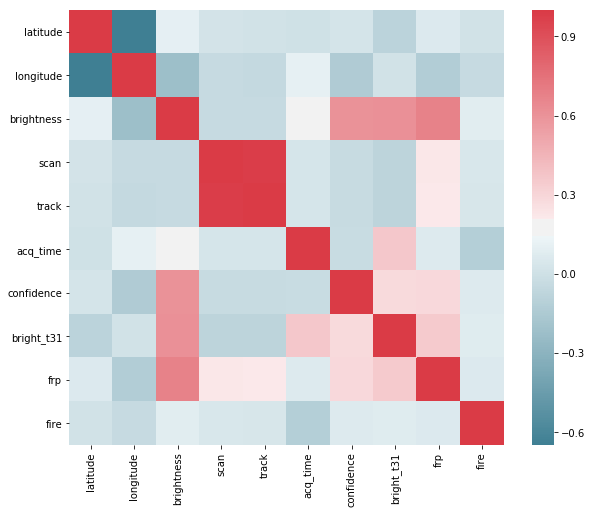

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = labeled_mh.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

## The saved Merged file is the main contribution of this notbook, below is some exploratory data analysis

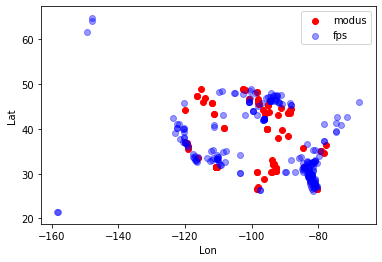

In [120]:
# this is a very low rate of overlap between our modis data and fps data, I'm going to explore an instance that 'should' appear in both and see where the mismatch is
# almost half of all fsa fires are missing a name,
# df['FIRE_NAME'].isna().sum()/len(df)
# but they all have a cause so I'm going to assume the causes are correct
# df['STAT_CAUSE_DESCR'].value_counts()

dfilter02 = (df['FIRE_YEAR'] == 2002) & (df['DISCOVERY_DOY'] == 150)

# df[dfilter02]

mfilter02 = (modis_df['FIRE_YEAR'] == 2002) & (modis_df['DISCOVERY_DOY'] == 150)
latlong = ['LAT_ROUND','LON_ROUND']

m02coords = modis_df[mfilter02][latlong]
d02coords = df[dfilter02][latlong]

# now plot them together

import matplotlib.pyplot as plt

# blot them together:
plt.scatter(m02coords['LON_ROUND'], m02coords['LAT_ROUND'], label='modus', color='r')
plt.scatter(d02coords['LON_ROUND'], d02coords['LAT_ROUND'], label='fps', color='b', alpha=0.4)
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend()
plt.show();